<a href="https://colab.research.google.com/github/luc-perso/covid-19-xRay/blob/main/code_by_stefan/Autoencoder_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#drive unzip





In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# cropped
!unzip -q '/content/drive/MyDrive/datas/data_cropped_lungs' -d '/content/'

In [ ]:
pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 96.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.1 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
    Found existing i

#Moduls

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import json
import random
import itertools 
from sklearn import metrics
from tensorflow.keras.optimizers import Adam
from scipy.ndimage.filters import gaussian_filter

#functions

In [ ]:
def path_creator(db_path1, lu_inf,tr_te_val, desease, img):
  path = data_paths['path'].loc[idx[[lu_inf], tr_te_val, desease, img]][0]
  full_file_path = os.path.join(db_path1, path)
  return full_file_path

def img_path_n_list(path,class_num):
  img_path_list =[]
  img_list=[]  
  
  for img in os.listdir(path):
    try:
      file_path = os.path.join(path, img)
      img_path_list.append(file_path)
  
      # I import the images in gray scale
      img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
      #img_array = img_array.astype(float) / 255.0
    except:
      continue
    img_list.append([img_array,class_num])
  return img_path_list, img_list

In [ ]:
def path_creator_old(db_path2,cov,img):
  path = cov +'/'+ img
  full_file_path = os.path.join(db_path2, path)
  return full_file_path


In [ ]:
def gaus(x):
  return cv2.GaussianBlur(x, (5, 5), 0)

In [ ]:
def extract(df,col):
  data=[]
  for i in df[col]:
    i = cv2.resize(i, (imsize,imsize))
    i=i.reshape(imsize,imsize,1)
    data.append(i)
  return data

In [ ]:
##### centering the image #######

def center(image):
  points = cv2.findNonZero(image) # find nonzero pixel
  #listing x and y values
  xlist=[]
  for i in range(0, points.shape[0]):
    x=points[i][0][0]
    xlist.append(x)

  ylist=[]
  for i in range(0, points.shape[0]):
    y=points[i][0][1]
    ylist.append(y)
 #define the edges of region of interest
  yb=min(ylist)
  ye=max(ylist)
  xb=min(xlist)
  xe=max(xlist)
 #cropping
  region_of_interest = image[yb:ye, xb:xe]
  # resizing to 256*256
  region_of_interest = cv2.resize(region_of_interest,dsize=(256, 256), interpolation = cv2.INTER_CUBIC)
  return region_of_interest

In [ ]:
###### data import#########
# method for data import to a list and df
#import in grayscale and dsize 256*256 
def data_n_frame(catdir,sub, column_name):
    data_name =[]
    for x in sub:
        path = os.path.join(catdir, x)

        for img in os.listdir(path):
            # I import the images in gray scale
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_array = cv2.resize(img_array, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
            data_name.append([img_array])
    dataframe = pd.DataFrame(data_name)
    dataframe = dataframe.rename(columns={0: column_name})

    return data_name, dataframe

In [ ]:
###### Classes Assignment #####
##for example, df_class = "covid"
def df_class( df_name,df_class):
    df_name["class"]= f"{df_class}"
    return df_name

In [ ]:
####### concatanate masks to xray ####
def concat(df_xray,df_mask):
    dataframe = pd.concat([df_xray, df_mask], axis = 1)
    return dataframe

In [ ]:
########masking xray ##########
## x = xray
## y = mask
def masked_xray(x,y):
  masked_image=cv2.bitwise_and(y, x,cv2.IMREAD_GRAYSCALE)
  return  masked_image


In [ ]:
def save_df(df, file_name, path):
    
    #df.to_csv("/content/drive/MyDrive/saves/"+ file_name + '.csv', index=False)
    df.to_hdf(path +'/'+file_name + '.h5', key="df", mode="w")

#augmentation

In [ ]:
seed=42
dir_imgs_train = '/content/data_cropped_lungs/Lung Segmentation Data/Train'
dir_imgs_val = '/content/data_cropped_lungs/Lung Segmentation Data/Val'
dir_imgs_test = '/content/data_cropped_lungs/Lung Segmentation Data/Test'
c_mode = "grayscale"
imsize = 112
batch_size=64

def custom_augmentation(np_tensor):
  np_tensor=np_tensor/255
  def random_contrast(np_tensor):
    return tf.clip_by_value(tf.image.random_contrast(np_tensor, 0.9,1),0,1)
    
  def random_brightness(np_tensor):        
    return tf.clip_by_value(tf.image.random_brightness(np_tensor,(0.2)),0,1)
 
  def random_gamma(np_tensor):
    gamma = tf.random.uniform([1], 0.9, 1)
    return tf.clip_by_value(tf.image.adjust_gamma(np_tensor, gamma),0,1)  

  def gaussian(np_tensor):
    np_tensor = tf.clip_by_value(gaussian_filter(np_tensor, sigma=0.6),0,1)
    return np_tensor

  np_tensor = random_gamma(np_tensor)
  np_tensor = random_brightness(np_tensor)     
  np_tensor = random_contrast(np_tensor)  
  np_tensor =gaussian(np_tensor)
  return np_tensor



train_data_generator = ImageDataGenerator(fill_mode='constant', cval=0,
                                         #rescale=1./255, 
                                         preprocessing_function = custom_augmentation,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         zoom_range=0.1,
                                         rotation_range=20)

train_generator = train_data_generator.flow_from_directory(directory=dir_imgs_train, 
                                                           class_mode="input",
                                                           target_size=(imsize,imsize), 
                                                           #color_mode=c_mode,
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

val_generator = ImageDataGenerator(rescale=1./255,fill_mode='constant', cval=0,).flow_from_directory(directory=dir_imgs_val, 
                                                           class_mode="input",
                                                           target_size=(imsize,imsize),
                                                           #color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

test_generator = ImageDataGenerator(rescale=1./255,fill_mode='constant', cval=0,).flow_from_directory(directory=dir_imgs_test, 
                                                           class_mode="input",
                                                           target_size=(imsize,imsize),
                                                           #color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = False,
                                                           seed = seed)

Found 21711 images belonging to 3 classes.
Found 4375 images belonging to 3 classes.
Found 6787 images belonging to 3 classes.


#autoencoder

####autoencoder

In [ ]:
#erster für alle classen funktioniert nicht gut
#Encoder
input_img =tf.keras.Input(shape=(imsize, imsize, 3),name='input')
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name= 'first_en')(input_img)
#x = tf.keras.layers.MaxPooling2D((2, 2), padding='same', name='pool1')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',name= 'nd_en')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',name= 'rd_en')(x)
#x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same',name= 'th_en')(x)
#x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name= 'encoded')(x)
#encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',name='first_de')(encoded)
#x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same',name= 'nd_de')(x)
#x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',name='rd_de')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',name='th_de')(x)
#x = tf.keras.layers.UpSampling2D((2, 2), name='up1')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',name='5th_de')(x)
decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='relu', padding='same', name='decoded')(x)
    
autoencoder = tf.keras.Model(input_img, decoded)
lr=0.001
autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mse',metrics=['mae'])
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 first_en (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 nd_en (Conv2D)              (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 rd_en (Conv2D)              (None, 112, 112, 128)     73856     
                                                                 
 th_en (Conv2D)              (None, 112, 112, 256)     295168    
                                                           

In [ ]:
lr=.001
autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mse',metrics=['mae'])
training_history=autoencoder.fit(train_generator  ,epochs=5, batch_size=32, validation_data=val_generator)

Epoch 1/5
340/340 [==============================] - 250s 722ms/step - loss: 0.0047 - mae: 0.0289 - val_loss: 0.0023 - val_mae: 0.0225
Epoch 2/5
340/340 [==============================] - 237s 698ms/step - loss: 2.6900e-04 - mae: 0.0097 - val_loss: 0.0018 - val_mae: 0.0197
Epoch 3/5
340/340 [==============================] - 232s 682ms/step - loss: 2.0413e-04 - mae: 0.0084 - val_loss: 0.0016 - val_mae: 0.0190
Epoch 4/5
340/340 [==============================] - 231s 678ms/step - loss: 1.7867e-04 - mae: 0.0078 - val_loss: 0.0016 - val_mae: 0.0190
Epoch 5/5
340/340 [==============================] - 234s 689ms/step - loss: 1.8812e-04 - mae: 0.0079 - val_loss: 0.0015 - val_mae: 0.0180


In [ ]:
#erster für alle classen funktioniert nicht gut
#Encoder
input_img =tf.keras.Input(shape=(imsize, imsize, 3),name='input')
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name= 'first_en')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same', name='pool1')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',name= 'nd_en')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
#x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',name= 'rd_en')(x)
#x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
#x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same',name= 'th_en')(x)
#x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name= 'encoded')(x)
#encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',name='first_de')(encoded)
#x = tf.keras.layers.UpSampling2D((2, 2))(x)
#x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same',name= 'nd_de')(x)
#x = tf.keras.layers.UpSampling2D((2, 2))(x)
#x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',name='rd_de')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',name='th_de')(x)
x = tf.keras.layers.UpSampling2D((2, 2), name='up1')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',name='5th_de')(x)
decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='relu', padding='same', name='decoded')(x)
    
autoencoder = tf.keras.Model(input_img, decoded)
lr=0.001
autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mse',metrics=['mae'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 112, 112, 3)]     0         
                                                                 
 first_en (Conv2D)           (None, 112, 112, 32)      896       
                                                                 
 pool1 (MaxPooling2D)        (None, 56, 56, 32)        0         
                                                                 
 nd_en (Conv2D)              (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 64)       0         
 )                                                               
                                                                 
 encoded (Conv2D)            (None, 28, 28, 64)        36928     
                                                             

####visual

In [ ]:
#Image Data Generator testing/tuning
imgs_batch= test_generator.next()

imgs_batch[1][0]
len(imgs_batch[0])

64

In [ ]:
model= autoencoder
index = 12
#img_class= imgs_batch[1]
img= imgs_batch[0]
img_t = img[index]
#img_class_t = img_class[index]
img_t = img_t[tf.newaxis, ...]
img=img_t

1/1 [==============================] - 0s 145ms/step
(1, 28, 28, 64)
1/1 [==============================] - 0s 145ms/step
(1, 112, 112, 3)


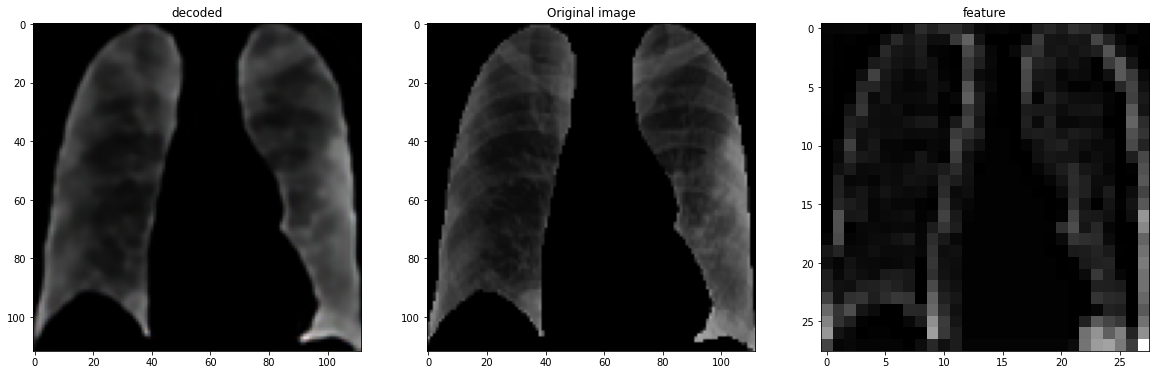

In [ ]:


last_conv_layer = autoencoder.get_layer('encoded')
encoder = tf.keras.Model(inputs=autoencoder.inputs, outputs=[last_conv_layer.output])

imgn=tf.reshape(img,(imsize,imsize,3))

encoded = encoder.predict(img)
print(encoded.shape)
encoded_img=encoded[:,:,:,6].reshape(encoded.shape[1],encoded.shape[2])
last_layer = autoencoder.get_layer('decoded')
decoder=tf.keras.Model(inputs=autoencoder.inputs, outputs=[last_layer.output])
decoded = decoder.predict(img)
decoded
print(decoded.shape)
decoded_img = decoded.reshape(imsize,imsize,3)

plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.imshow(decoded_img, cmap='gray')
plt.title('decoded')

plt.subplot(1,3,2)
plt.imshow(imgn,cmap='gray')
plt.title('Original image')

plt.subplot(1,3,3)
plt.imshow(encoded_img,cmap='gray')
plt.title('feature')

plt.show();

####Feature maps

In [ ]:
#Image Data Generator testing/tuning
imgs_batch= train_generator.next()

imgs_batch[1][0]
imgs_batch[1].shape

(64, 3)

In [ ]:
from tensorflow.keras import Model
# redefine model to output right after the first hidden layer
ixs = [1, 2, 4,5,7]
outputs = [autoencoder.layers[i].output for i in ixs]
feat_model = Model(inputs=autoencoder.inputs, outputs=outputs)
feat_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 112, 112, 3)]     0         
                                                                 
 first_en (Conv2D)           (None, 112, 112, 32)      896       
                                                                 
 pool1 (MaxPooling2D)        (None, 56, 56, 32)        0         
                                                                 
 nd_en (Conv2D)              (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 encoded (Conv2D)            (None, 28, 28, 64)        36928     
                                                          

In [ ]:
feature_maps = feat_model.predict(img)

2/2 [==============================] - 1s 249ms/step


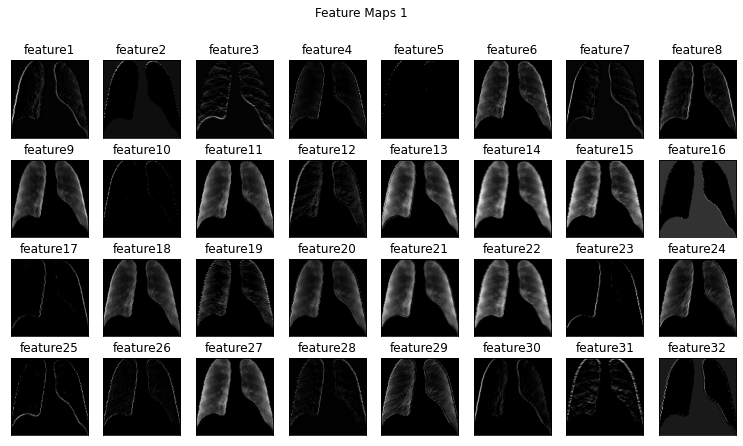

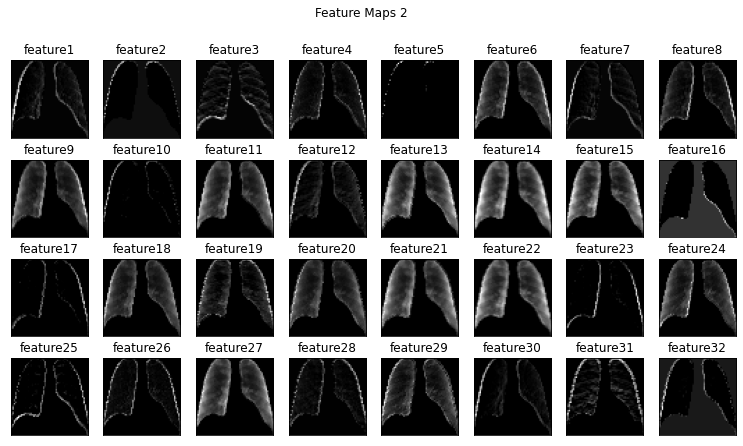

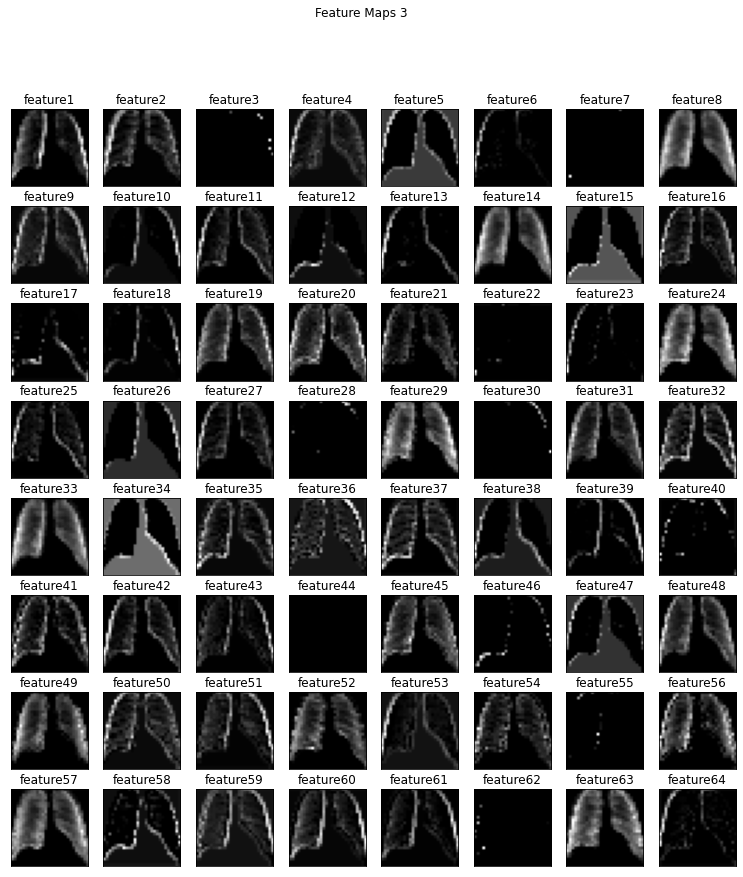

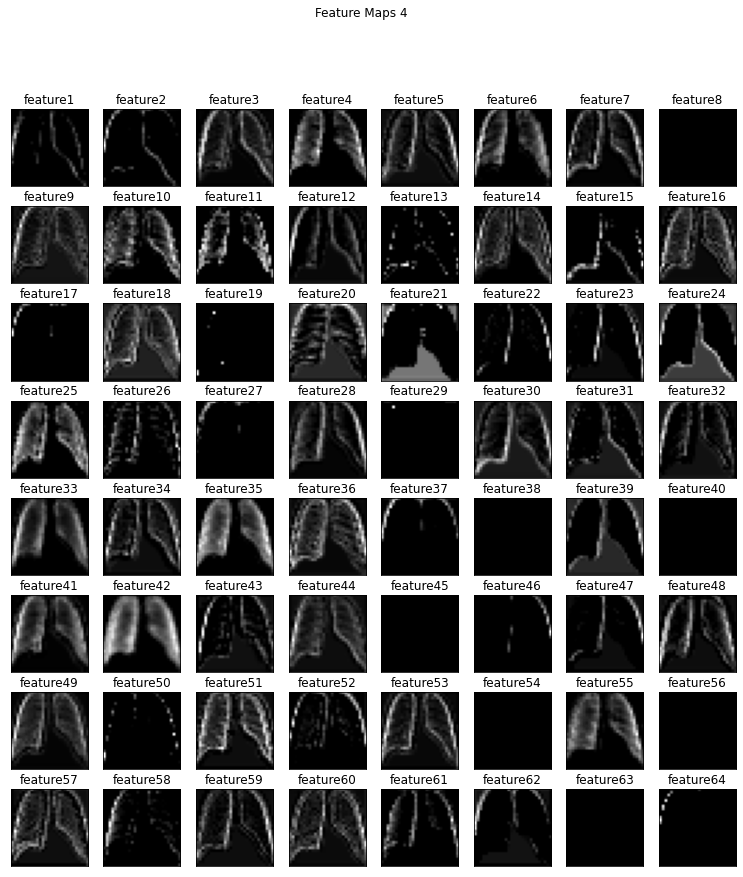

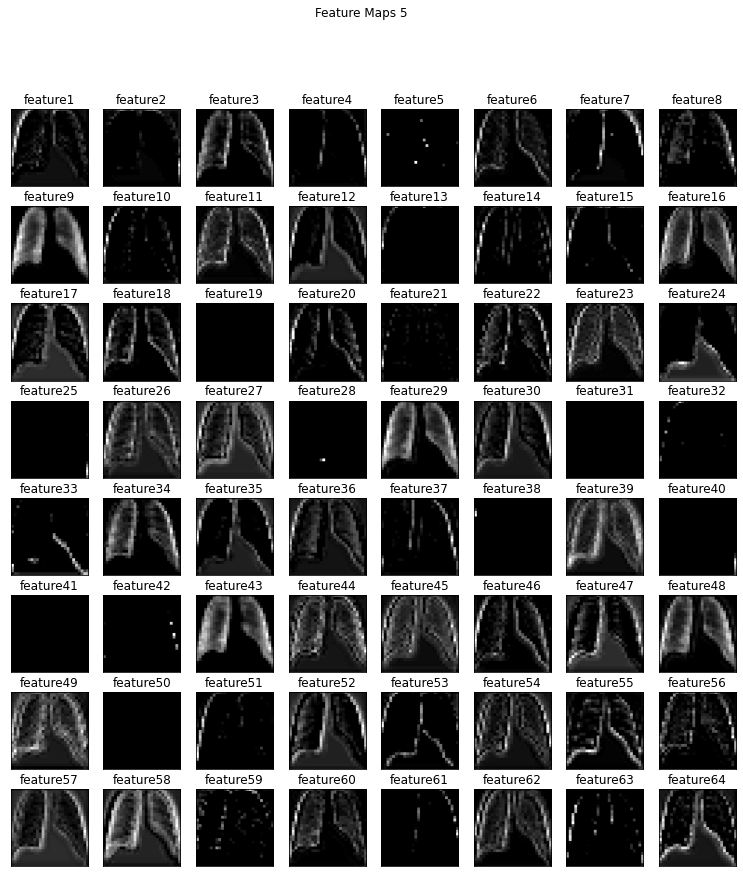

In [ ]:

count=1
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    square = int((fmap.shape[-1])/8)
    square2 = 8
    if square <= 4:
        figsize = (13, 7)
    elif square <= 8:
        figsize = (13,14)
    elif square <= 16:
        figsize = (13, 28)   
    elif square <= 32:
        figsize = (13, 56)     
    plt.figure(figsize=figsize)
    plt.suptitle("Feature Maps " + str(count))
    for _ in range(square2):
        for _ in range(square):
            if (ix-1) < fmap.shape[-1]:
                # specify subplot and turn of axis
                ax = plt.subplot(square, square2, ix)
                ax.set_title("feature" + str(ix))
                ax.set_xticks([])
                ax.set_yticks([])
            
                # plot filter channel in grayscale
                plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
            
                ix += 1
            else:
                break
    count += 1 
    # show the figure
    plt.show()

####transfer

In [ ]:
seed=42
dir_imgs_train = '/content/data_cropped_lungs/Lung Segmentation Data/Train'
dir_imgs_val = '/content/data_cropped_lungs/Lung Segmentation Data/Val'
dir_imgs_test = '/content/data_cropped_lungs/Lung Segmentation Data/Test'
c_mode = "grayscale"#"rgb"#"
imsize = 112
batch_size=64

def custom_augmentation(np_tensor):
  np_tensor=np_tensor/255
  def random_contrast(np_tensor):
    return tf.clip_by_value(tf.image.random_contrast(np_tensor, 0.9,1),0,1)
    
  def random_brightness(np_tensor):        
    return tf.clip_by_value(tf.image.random_brightness(np_tensor,(0.2)),0,1)
 
  def random_gamma(np_tensor):
    gamma = tf.random.uniform([1], 0.9, 1)
    return tf.clip_by_value(tf.image.adjust_gamma(np_tensor, gamma),0,1)  

  def gaussian(np_tensor):
    np_tensor = tf.clip_by_value(gaussian_filter(np_tensor, sigma=0.6),0,1)
    return np_tensor

  np_tensor = random_gamma(np_tensor)
  np_tensor = random_brightness(np_tensor)     
  np_tensor = random_contrast(np_tensor)  
  np_tensor =gaussian(np_tensor)
  return np_tensor



train_data_generator = ImageDataGenerator(fill_mode='constant', cval=0,
                                         #rescale=1./255, 
                                         preprocessing_function = custom_augmentation,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         zoom_range=0.1,
                                         rotation_range=20)

train_generator = train_data_generator.flow_from_directory(directory=dir_imgs_train, 
                                                           class_mode="categorical",
                                                           target_size=(imsize,imsize), 
                                                           #color_mode=c_mode,
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

val_generator = ImageDataGenerator(rescale=1./255,fill_mode='constant', cval=0,).flow_from_directory(directory=dir_imgs_val, 
                                                           class_mode="categorical",
                                                           target_size=(imsize,imsize),
                                                           #color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

test_generator = ImageDataGenerator(rescale=1./255,fill_mode='constant', cval=0,).flow_from_directory(directory=dir_imgs_test, 
                                                           class_mode="categorical",
                                                           target_size=(imsize,imsize),
                                                           #color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = False,
                                                           seed = seed)

Found 21711 images belonging to 3 classes.
Found 4375 images belonging to 3 classes.
Found 6787 images belonging to 3 classes.


In [ ]:
input_layers = [autoencoder.layers[i].output for i in range(len(autoencoder.layers) -6)]
new_model = tf.keras.Model(inputs=autoencoder.input, outputs=input_layers)

In [ ]:
for layer in new_model.layers:

  layer.trainable = False

In [ ]:
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 112, 112, 3)]     0         
                                                                 
 first_en (Conv2D)           (None, 112, 112, 32)      896       
                                                                 
 pool1 (MaxPooling2D)        (None, 56, 56, 32)        0         
                                                                 
 nd_en (Conv2D)              (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 encoded (Conv2D)            (None, 28, 28, 64)        36928     
                                                           

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout

inputs = tf.keras.layers.Input(shape=(imsize, imsize, 3))

x = new_model(inputs)
x = x[-1]

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=16, activation='relu')(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
outputs = tf.keras.layers.Dense(units=3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                  loss="categorical_crossentropy",
                  metrics=["acc"])

model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 model_8 (Functional)        [(None, 112, 112, 3),     56320     
                              (None, 112, 112, 32),              
                              (None, 56, 56, 32),                
                              (None, 56, 56, 64),                
                              (None, 28, 28, 64),                
                              (None, 28, 28, 64)]                
                                                                 
 flatten_3 (Flatten)         (None, 50176)             0         
                                                                 
 dense_8 (Dense)             (None, 16)                802832    
                                                           

In [ ]:
initial_learning_rate = 0.002
steps=3
decay=0.6
min_delta=0
patience=5
monitor="val_loss"
epochs=20

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= initial_learning_rate,
                                                             decay_steps=steps, 
                                                             decay_rate=decay,
                                                             staircase=True)

lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")

@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,
    min_delta=min_delta,
    patience=patience,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)


class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch

stopper = EpochStopper()
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
training_history = model.fit(train_generator,
                             validation_data = val_generator,         
                             epochs = epochs,                         
                             callbacks=[lr_callback, es_callback, stopper])

Epoch 1/20
340/340 [==============================] - 202s 589ms/step - loss: 0.9140 - accuracy: 0.5348 - val_loss: 0.8254 - val_accuracy: 0.6645 - lr: 0.0020
Epoch 2/20
340/340 [==============================] - 200s 589ms/step - loss: 0.9167 - accuracy: 0.5355 - val_loss: 0.8284 - val_accuracy: 0.6448 - lr: 0.0020
Epoch 3/20
340/340 [==============================] - 201s 591ms/step - loss: 0.9150 - accuracy: 0.5395 - val_loss: 0.8410 - val_accuracy: 0.6585 - lr: 0.0020
Epoch 4/20
340/340 [==============================] - 203s 598ms/step - loss: 0.9061 - accuracy: 0.5396 - val_loss: 0.8114 - val_accuracy: 0.6745 - lr: 0.0012
Epoch 5/20
340/340 [==============================] - 200s 589ms/step - loss: 0.9086 - accuracy: 0.5389 - val_loss: 0.8097 - val_accuracy: 0.6752 - lr: 0.0012
Epoch 6/20
340/340 [==============================] - 199s 585ms/step - loss: 0.9071 - accuracy: 0.5410 - val_loss: 0.7906 - val_accuracy: 0.6793 - lr: 0.0012
Epoch 7/20
340/340 [==========================

####heatmap CAM

In [ ]:
index = 7
img_class= imgs_batch[1]
img= imgs_batch[0]
img_t = img[index]
img_class_t = img_class[index]
img_t = img_t[tf.newaxis, ...]

In [ ]:
last_conv_layer = new_model.get_layer('encoded')
model_fm = tf.keras.Model(inputs=new_model.inputs, outputs=[last_conv_layer.output])

In [ ]:
feature_maps = model_fm.predict(img_t)
model_out= model.predict(img_t)

feature_maps = np.squeeze(feature_maps)
model_out = np.squeeze(model_out)
weights = model.layers[-1].weights[0]
print(weights.shape)     
max_idx = np.argmax( model_out )
print(f"Max index: {max_idx} ({model_out[max_idx]*100:.2f}%)")

1/1 [==============================] - 0s 29ms/step
(64, 3)
Max index: 1 (86.10%)


In [ ]:
winning_weights = weights[:, max_idx]
CAM = np.zeros(feature_maps.shape[:2])
for k, wk in enumerate(winning_weights):
    # get feature map k
    feature_map_k = feature_maps[..., k]
    
    # get activation of map k (multiply Fk with wk)
    activation_k = feature_map_k * wk
    
    CAM += activation_k

In [ ]:
CAM=CAM.numpy()
img_t=img_t.reshape(imsize,imsize,3)
print(img_t.shape)
CAM.shape

(112, 112, 3)


(28, 28)

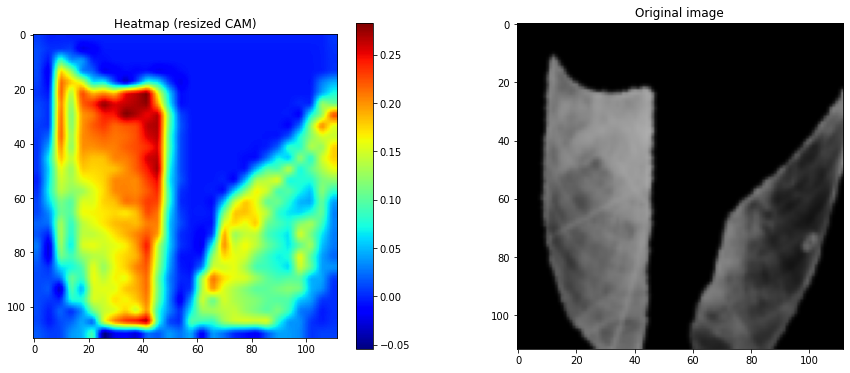

In [ ]:
# resize CAM
heatmap = cv2.resize(CAM, (img_t.shape[1], img_t.shape[0]))

# plot heatmap and image side by side
plt.subplots(1, 2, figsize=(15, 6))

plt.subplot(1,2,1)
plt.imshow(heatmap,cmap="jet")
plt.title('Heatmap (resized CAM)')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(img_t)
plt.title('Original image')

plt.show()

pred class: 1 (86.10%)
class: 1


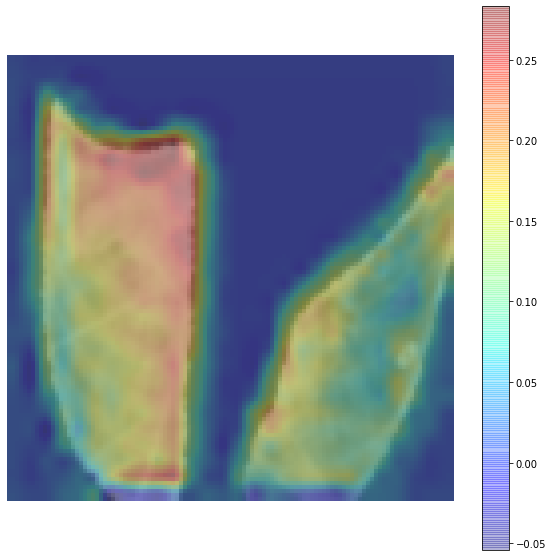

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(img_t, alpha=0.7, cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.3)
print(f"pred class: {max_idx} ({model_out[max_idx]*100:.2f}%)")
print(f"class: {np.argmax(img_class_t)}")
plt.axis('off')
plt.colorbar()

plt.show()

Max of heatmap: 0.28
Cut-off value: 0.11


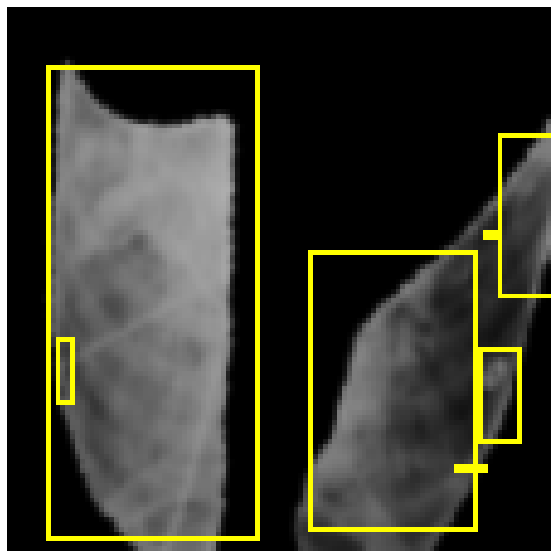

In [ ]:
import matplotlib.patches as patches

heatmap_max = np.max(heatmap)
print("Max of heatmap: %.2f" % heatmap_max)

boundary = heatmap_max * 0.4
print("Cut-off value: %.2f" % boundary)

bbox_heatmap = heatmap.copy()
bbox_heatmap = np.where(bbox_heatmap <= boundary, 0, 255)

gray = img_t #cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

bbox_img = img_t.copy()
bbox_img = np.reshape(bbox_img,(imsize,imsize,3))
# find contours of heatmap
cnts = cv2.findContours(bbox_heatmap.astype('uint8'),
                        cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

offset = 1
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(bbox_img, (x+offset, y+offset),
                  (x+offset + w, y + h), (100,255,0), 1)

plt.figure(figsize=(10,10))
plt.imshow(bbox_img, cmap='gray')
#plt.title(f'{label} with confidence {conf*100:.2f}%')
plt.axis('off')

plt.show()